In [100]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import datetime
from datetime import timedelta
import cc_vars as cc
import warnings

#Variables
file =  'Customer Service Daily AHT Volume.xlsx'
grps = cc.grp_dict()
holidays = pd.Series(cc.holiday_lis())

#Functions
def clean_data(f,g,tab='Volume',aht_or_vol='vol'):
    """Prepare data into two pandas dataframes - one seperated by split, 
       the other seperated into departmental sub-groups."""
    df = pd.read_excel(file, sheet_name = tab).fillna(0)
    df.index = df['Split']
    df.insert(0,'Forecast_Grp',df['Split'].map(g))
    df = df.loc[df['Forecast_Grp'].isna() == False]
    df = df.sort_values(by=['Forecast_Grp'])
    save =  pd.DataFrame(df['Forecast_Grp'], index=df.index)
    df = df.drop(['Forecast_Grp','Split','Group'],axis=1)
    df.columns = pd.to_datetime(df.columns)
    df = df.loc[:, ~df.columns.weekday.isin([5,6])] 
    df.insert(0,'Forecast_Grp',save)
    grp_df = df.reset_index(drop=True)
    if aht_or_vol == 'vol':
        table = pd.pivot_table(grp_df, columns = ['Forecast_Grp'], aggfunc = np.sum)
    elif aht_or_vol == 'aht':
        table = pd.pivot_table(grp_df, columns = ['Forecast_Grp'], aggfunc = np.mean)
    table.index = table.index.rename('Date')
    df = df.transpose()
    df = df[df.index != 'Forecast_Grp']
    df.index = df.index.rename('Date')
    delta = int((df.index[-1] - df.index[0]).days) + 1
    arr = np.array([df.index[0] + datetime.timedelta(days=i) for i in range(delta)])
    empty = pd.DataFrame(columns = df.columns, index=arr).fillna(0)
    empty_table = pd.DataFrame(columns = table.columns, index=arr).fillna(0)
    empty.loc[df.index] = df   
    empty_table.loc[table.index] = table
    weekday_filter = {'Date':arr,'Day':pd.Series(arr).dt.day_name()}
    wdf = pd.DataFrame(weekday_filter)
    wdf.index = wdf['Date']
    empty.loc[wdf['Day'] == 'Sunday'] = 0
    empty.loc[wdf['Day'] == 'Saturday'] = 0
    empty_table.loc[wdf['Day'] == 'Sunday'] = 0
    empty_table.loc[wdf['Day'] == 'Saturday'] = 0
    df = empty
    table = empty_table
    return df, table

def weekend_doub_hol(day,f,pr1,pr2,pr3,df_nh,df_ph,date_df):
    """The days following holidays (especially after two day holidays or holidays back-to-back with a weekend) typically
        have a much higher call volume and AHT. This function determines sets a heavier weight to days 
        more closely following a specific date."""
    dates = date_df.tolist()
    str_dates = []
    for i in dates:
        str_dates.append(str(i))
    fut_d = datetime.datetime.strftime(day - timedelta(days=f), "%Y-%m-%d %H:%M:%S")
    prev_date_1 = datetime.datetime.strftime(day + timedelta(days=pr1), "%Y-%m-%d %H:%M:%S")
    prev_date_2 = datetime.datetime.strftime(day + timedelta(days=pr2), "%Y-%m-%d %H:%M:%S")
    prev_date_3 = datetime.datetime.strftime(day + timedelta(days=pr3), "%Y-%m-%d %H:%M:%S")
    if fut_d not in str_dates:
        df_ph.loc[prev_date_1] = 1
        df_ph.loc[prev_date_2] = 0.5
        df_ph.loc[prev_date_3] = 0.3333
    elif prev_date_1 not in str_dates:
        df_nh.loc[fut_d] = 1
    elif prev_date_2 not in str_dates:
        df_nh.loc[fut_d] = 1
        df_ph.loc[prev_date_1] = 1
    elif prev_date_3 not in str_dates:
        df_nh.loc[fut_d] = 1
        df_ph.loc[prev_date_1] = 1
        df_ph.loc[prev_date_2] = 0.5
    else:
        df_nh.loc[fut_d] = 1
        df_ph.loc[prev_date_1] = 1
        df_ph.loc[prev_date_2] = 0.5
        df_ph.loc[prev_date_3] = 0.3333

def distance_from_holiday(date_series,holiday_series):
    """Applies weekend_doub_hol to list of dates scheduled as holidays for the call center. Iterates through 
       holidays that fall on different days of the week as the day of week changes the (i.e. a holiday on a Friday
       will result in more calls on Monday since the call center is closed on the weekend)."""
    date_frame = pd.DataFrame(columns = ['holiday','next_hol','prev_hol'],index=date_series).fillna(0)
    holidays_bool = date_frame.index.isin(np.array(holiday_series))
    day_of_week = np.array(pd.Series(date_frame.index).dt.dayofweek)
    date_frame['holiday'].loc[holidays_bool] = 1
    for hol in holiday_series.tolist():
        if hol in date_series.tolist():
            d = datetime.datetime.strptime(str(hol), "%Y-%m-%d %H:%M:%S")
            test_doub_fut = datetime.datetime.strftime(d + timedelta(days=1), "%Y-%m-%d %H:%M:%S")
            test_doub_pas = datetime.datetime.strftime(d - timedelta(days=1), "%Y-%m-%d %H:%M:%S")
            if hol.day_name() == 'Monday':
                if date_frame['holiday'].loc[test_doub_fut] == 1:
                    weekend_doub_hol(d,3,2,3,4,date_frame['next_hol'],date_frame['prev_hol'],date_series)
                else:
                    weekend_doub_hol(d,3,1,2,3,date_frame['next_hol'],date_frame['prev_hol'],date_series)
            elif hol.day_name() == 'Friday':
                if date_frame['holiday'].loc[test_doub_pas] == 1:
                    weekend_doub_hol(d,2,3,4,5,date_frame['next_hol'],date_frame['prev_hol'],date_series)
                else:
                    weekend_doub_hol(d,1,3,4,5,date_frame['next_hol'],date_frame['prev_hol'],date_series)
            elif hol.day_name() == 'Thursday':
                if date_frame['holiday'].loc[test_doub_fut] == 1:
                    weekend_doub_hol(d,1,4,5,6,date_frame['next_hol'],date_frame['prev_hol'],date_series)
                elif date_frame['holiday'].loc[test_doub_pas] == 1:
                    weekend_doub_hol(d,2,1,4,6,date_frame['next_hol'],date_frame['prev_hol'],date_series)
            elif hol.day_name() == 'Wednesday':
                if date_frame['holiday'].loc[test_doub_fut] == 1:
                    weekend_doub_hol(d,1,2,5,6,date_frame['next_hol'],date_frame['prev_hol'],date_series)
                elif date_frame['holiday'].loc[test_doub_pas] == 1:
                    weekend_doub_hol(d,2,1,2,5,date_frame['next_hol'],date_frame['prev_hol'],date_series)
            elif hol.day_name() == 'Tuesday':
                if date_frame['holiday'].loc[test_doub_fut] == 1:
                    weekend_doub_hol(d,1,2,3,4,date_frame['next_hol'],date_frame['prev_hol'],date_series)
                elif date_frame['holiday'].loc[test_doub_pas] == 1:
                    weekend_doub_hol(d,4,1,2,3,date_frame['next_hol'],date_frame['prev_hol'],date_series)
        else:
            pass
    return date_frame

def mask(dataframe,start_datetime,end_datetime):
    """Simple date range filter."""
    m = ((dataframe >= start_datetime) & (dataframe < end_datetime))
    return m

def forecast(grp_data,date_df,days_forecast=30):
    """Pre-process pandas dataframe (either grouped by split or by departmental sub-group) and concat future dates
       to forecast onto dataframe."""
    strt = datetime.datetime.strftime(date_df.tolist()[-1] + timedelta(days=1), "%Y-%m-%d %H:%M:%S")
    lst = datetime.datetime.strftime(date_df.tolist()[-1] + timedelta(days=days_forecast), "%Y-%m-%d %H:%M:%S")
    rng = pd.date_range(start=strt, end=lst)
    x = pd.Series(index = rng)
    x = grp_data.append(x).fillna(0)
    f_dates = date_df.append(pd.DatetimeIndex.to_series(rng),ignore_index=True)
    hol_df = distance_from_holiday(f_dates,holidays)
    x = pd.DataFrame({'volume':x.values.tolist(),'year':f_dates.dt.year.tolist(),'week':f_dates.dt.week.tolist(), 
                        'day_of_week':f_dates.dt.day_name().tolist(),'month':f_dates.dt.month_name().tolist(),
                        'next_holiday':hol_df['next_hol'],'previous_holiday':hol_df['prev_hol'],
                        'holiday':hol_df['holiday']})
    f_scaler = preprocessing.MinMaxScaler()
    f_dummies = pd.get_dummies(x[['year','week','day_of_week','month']].astype(str))
    f_dummies.index = f_dates
    x = pd.merge(x[['volume','holiday','next_holiday','previous_holiday']],
                   f_dummies,how='outer',left_index=True, right_index=True)
    y = x['volume']
    x = pd.DataFrame(f_scaler.fit_transform(x),columns=x.columns,index=x.index).drop('volume',axis=1)
    return x,y

def find_params(xtrain, ytrain, xtest, ytest, est, min_samp):
    """Used to tune Hyperparameters for random forest regression"""
    error_dict = {};
    for e in est:
        for ms in min_samp:
            md = None
            rfr = RandomForestRegressor(n_estimators=int(e), max_depth=md, min_samples_split=int(ms), random_state=100)
            rfr = rfr.fit(xtrain, ytrain)
            rfr_test = rfr.predict(xtest)
            param_lis = [e,md,ms]
            di = {format(param_lis):round(mean_squared_error(rfr_test, ytest))};
            print(di)
            error_dict.update(di);
    k = min(error_dict.keys(), key=(lambda k: error_dict[k]))
    print(k)
    return k

vol, grp_vol = clean_data(file,grps)
grp_vol.tail(7)

Forecast_Grp,dept_10a,dept_11a,dept_1a,dept_1b,dept_1c,dept_2a,dept_2b,dept_2c,dept_2d,dept_3a,...,dept_4b,dept_4c,dept_4d,dept_4e,dept_5a,dept_6a,dept_7a,dept_7b,dept_8a,dept_9a
2020-11-10,240.0,2.0,1030.0,193.0,389.0,229.0,133.0,226.0,29.0,610.0,...,84.0,377.0,243.0,39.0,131.0,214.0,59.0,155.0,611.0,286.0
2020-11-11,178.0,0.0,829.0,168.0,300.0,171.0,62.0,159.0,28.0,461.0,...,35.0,333.0,218.0,31.0,96.0,175.0,32.0,129.0,503.0,216.0
2020-11-12,180.0,0.0,789.0,150.0,325.0,233.0,125.0,153.0,27.0,443.0,...,76.0,288.0,176.0,35.0,107.0,182.0,43.0,146.0,450.0,247.0
2020-11-13,218.0,0.0,873.0,142.0,394.0,200.0,119.0,229.0,29.0,473.0,...,61.0,325.0,246.0,40.0,90.0,179.0,37.0,155.0,418.0,274.0
2020-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-16,256.0,3.0,1240.0,174.0,546.0,290.0,154.0,271.0,33.0,555.0,...,76.0,365.0,257.0,55.0,127.0,261.0,44.0,216.0,672.0,329.0


In [111]:
#Train Data on dept_9a
test_grp = grp_vol['dept_9a']
dates = pd.Series(test_grp.index)
X, y = forecast(test_grp,dates)
msk = mask(X.index,datetime.datetime(2018,1,1),datetime.datetime(2020,11,17))
X_train = X.loc[msk][:-30]
y_train = y.loc[msk][:-30]
X_test = X.loc[msk][-30:]
y_test = y.loc[msk][-30:]
X_forecast = X.loc[msk == False]

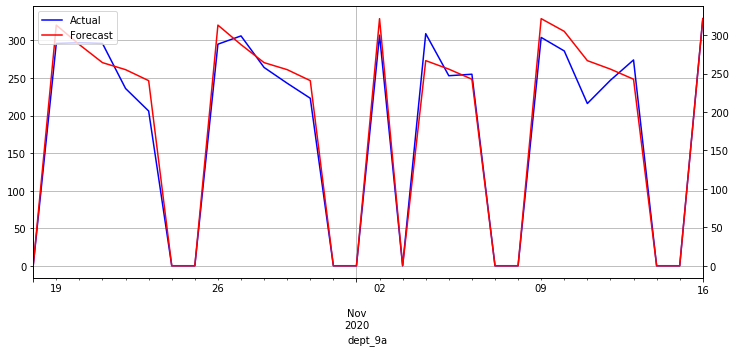

,y_test,rfr_test
2020-10-18,0.0,0.000000
2020-10-19,296.0,312.960784
2020-10-20,297.0,287.588235
2020-10-21,296.0,264.156863
2020-10-22,236.0,255.039216
2020-10-23,206.0,240.745098
2020-10-24,0.0,0.000000
2020-10-25,0.0,0.000000
2020-10-26,295.0,312.960784
2020-10-27,306.0,287.588235


In [112]:
#Forecast using Random Forest Regression 
rfr = RandomForestRegressor(n_estimators=51, max_depth=None,
                            min_samples_split=2, random_state=10).fit(X_train, y_train)  
rfr_test = rfr.predict(X_test)   
rfr_df = pd.DataFrame(columns = ['y_test', 'rfr_test'])
rfr_df['y_test'] = y_test
rfr_df['rfr_test'] = rfr_test

#Plot and print test data
plt.figure(figsize=(12,5))
plt.xlabel('dept_9a')
ax1 = rfr_df['y_test'].plot(color='blue', grid=True, label='Actual')
ax2 = rfr_df['rfr_test'].plot(color='red', grid=True, secondary_y=True, label='Forecast')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

rfr_df

In [113]:
#Forecast for all groups for next 30 days
cols = grp_vol.columns.tolist()
forecasts_df = pd.DataFrame(columns=cols)
for g in cols:
    data = grp_vol[g]
    dates = pd.Series(data.index)
    X, y = forecast(data,dates)
    msk = mask(X.index,datetime.datetime(2018,1,1),datetime.datetime(2020,11,17))
    X_train = X.loc[msk][:-30]
    y_train = y.loc[msk][:-30]
    X_forecast = X.loc[msk == False]
    rfr = RandomForestRegressor(n_estimators=51, max_depth=None,
                                min_samples_split=2, random_state=10)
    rfr = rfr.fit(X_train, y_train)
    forecasts_df[g] = rfr.predict(X_forecast)
forecasts_df.index = X_forecast.index
forecasts_df

,dept_10a,dept_11a,dept_1a,dept_1b,dept_1c,dept_2a,dept_2b,dept_2c,dept_2d,dept_3a,...,dept_4b,dept_4c,dept_4d,dept_4e,dept_5a,dept_6a,dept_7a,dept_7b,dept_8a,dept_9a
2020-11-17,205.960784,0.078431,865.098039,194.705882,450.588235,255.117647,112.745098,235.745098,30.450980,604.117647,...,12.392157,359.078431,236.254902,43.176471,105.000000,159.215686,51.803922,184.098039,955.549020,304.843137
2020-11-18,201.588235,0.058824,752.294118,168.764706,389.686275,219.392157,105.607843,191.823529,35.196078,553.274510,...,11.019608,320.686275,205.254902,35.627451,100.490196,176.352941,46.176471,162.529412,830.882353,266.764706
2020-11-19,187.960784,0.039216,698.980392,163.411765,345.960784,216.176471,104.333333,177.627451,35.176471,461.450980,...,9.745098,293.862745,197.000000,31.960784,97.901961,163.039216,37.764706,151.039216,782.529412,255.705882
2020-11-20,190.529412,0.039216,702.686275,125.274510,332.372549,203.647059,84.039216,172.568627,38.490196,453.705882,...,11.666667,305.156863,198.372549,34.176471,106.019608,158.784314,42.392157,154.156863,796.372549,242.607843
2020-11-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-11-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-11-23,230.588235,0.078431,1195.882353,189.941176,572.490196,275.509804,116.745098,277.196078,30.941176,669.549020,...,14.823529,432.509804,287.450980,48.568627,137.529412,234.705882,55.666667,224.862745,1120.784314,321.372549
2020-11-24,205.960784,0.078431,865.098039,194.705882,450.588235,255.117647,112.745098,222.176471,26.372549,604.117647,...,12.392157,359.078431,244.921569,41.882353,101.058824,166.019608,43.843137,147.843137,906.137255,304.843137
2020-11-25,202.274510,0.450980,745.372549,168.764706,389.686275,218.294118,98.549020,182.019608,25.274510,532.725490,...,11.921569,316.039216,209.333333,39.176471,81.098039,170.784314,46.019608,140.058824,754.490196,266.764706
2020-11-26,0.000000,0.019608,0.000000,0.000000,22.509804,0.000000,0.000000,0.000000,0.254902,0.000000,...,1.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
